In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
import time
from datetime import datetime
TQDM_AVAILABLE = True

# 1. Load all filtered anomalous data files
def load_anomalous_data(data_dir='filtered_data'):
    """Load and combine all filtered anomalous data files, adding location info."""
    all_files = glob.glob(f'{data_dir}/*_filtered.csv')
    data_frames = []
    
    for file_path in all_files:
        try:
            location = os.path.basename(file_path).replace('_filtered.csv', '')
            df = pd.read_csv(file_path)
            df['location'] = location
            data_frames.append(df)
            print(f"Loaded {location} - {len(df)} rows")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    combined_df = pd.concat(data_frames, ignore_index=True)
    print(f"Total combined data: {len(combined_df)} rows")
    return combined_df

# 2. Preprocess and clean data
def preprocess_data(df):
    """Handle missing values, standardize columns, and prepare data."""
    print("\nPreprocessing data...")
    df = df.copy()
    
    # Convert timestamp to datetime if present
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Ensure critical columns exist
    critical_cols = ['voltage', 'current', 'frequency', 'power', 'powerFactor']
    for col in critical_cols:
        if col not in df.columns:
            raise ValueError(f"Critical column '{col}' missing from data")
    
    # Handle missing values
    print(f"Missing values before: {df[critical_cols].isna().sum().sum()}")
    
    # Group by location and interpolate within each location
    df = df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
    
    # If any remaining NaNs, fill with median values by location
    for loc in df['location'].unique():
        loc_mask = df['location'] == loc
        for col in critical_cols:
            median_val = df.loc[loc_mask, col].median()
            df.loc[loc_mask, col] = df.loc[loc_mask, col].fillna(median_val)
    
    # Drop any rows that still have NaN in critical columns
    df = df.dropna(subset=critical_cols)
    print(f"Missing values after: {df[critical_cols].isna().sum().sum()}")
    print(f"Rows after handling missing values: {len(df)}")
    
    return df

# 3. Feature Engineering
def engineer_features(df):
    """Create detailed features to help distinguish anomaly types."""
    print("\nEngineering features...")
    df = df.copy()
    
    # Define nominal/ideal values for Philippines power systems
    NOMINAL_VOLTAGE = 230.0    # Nominal voltage for Philippines (V)
    IDEAL_FREQUENCY = 60.0     # Ideal frequency (Hz)
    IDEAL_POWER_FACTOR = 1.0   # Ideal power factor
    
    # Calculate deviations from nominal values
    df['voltage_deviation'] = (df['voltage'] - NOMINAL_VOLTAGE) / NOMINAL_VOLTAGE
    df['frequency_deviation'] = (df['frequency'] - IDEAL_FREQUENCY) / IDEAL_FREQUENCY
    df['pf_deviation'] = df['powerFactor'] - IDEAL_POWER_FACTOR
    
    # DETAILED VOLTAGE ANOMALY CATEGORIES
    df['severe_voltage_dip'] = ((df['voltage'] < 195.0)).astype(int)
    df['moderate_voltage_dip'] = ((df['voltage'] >= 195.0) & (df['voltage'] < 207.0)).astype(int)
    df['mild_voltage_dip'] = ((df['voltage'] >= 207.0) & (df['voltage'] < 217.4)).astype(int)
    
    df['mild_surge'] = ((df['voltage'] > 242.6) & (df['voltage'] <= 248.0)).astype(int)
    df['moderate_surge'] = ((df['voltage'] > 248.0) & (df['voltage'] <= 253.0)).astype(int)
    df['severe_surge'] = ((df['voltage'] > 253.0)).astype(int)
    
    # DETAILED POWER FACTOR ANOMALY CATEGORIES
    df['severe_pf_issue'] = ((df['powerFactor'] < 0.5)).astype(int)
    df['moderate_pf_issue'] = ((df['powerFactor'] >= 0.5) & (df['powerFactor'] < 0.7)).astype(int)
    df['mild_pf_issue'] = ((df['powerFactor'] >= 0.7) & (df['powerFactor'] < 0.792)).astype(int)
    
    # FREQUENCY ANOMALIES
    df['freq_low'] = ((df['frequency'] < 59.2)).astype(int)
    df['freq_high'] = ((df['frequency'] > 60.8)).astype(int)
    
    # LOAD AND POWER ANOMALIES
    df['high_current'] = (df['current'] > 10.0).astype(int)
    df['very_high_current'] = (df['current'] > 20.0).astype(int)
    df['high_power'] = (df['power'] > 1000.0).astype(int)
    df['very_high_power'] = (df['power'] > 3000.0).astype(int)
    
    # Original basic flags (for compatibility)
    df['transient_flag'] = ((df['voltage'] < 207.0) & (df['frequency'] > 59.0) & 
                           (df['frequency'] < 61.0)).astype(int)
    df['surge_flag'] = ((df['voltage'] > 248.0) & (df['frequency'] > 59.0) & 
                       (df['frequency'] < 61.0)).astype(int)
    df['pf_issue_flag'] = (df['powerFactor'] < 0.75).astype(int)
    
    # Create ratios (useful for detecting unusual load patterns)
    df['power_voltage_ratio'] = df['power'] / (df['voltage'] + 0.1)
    df['current_voltage_ratio'] = df['current'] / (df['voltage'] + 0.1)
    
    return df

# 4. Reduce data while preserving meaningful patterns
def reduce_data(df, max_samples=20000):
    """Reduce dataset size while ensuring balanced representation of anomaly types."""
    print("\nReducing data...")
    original_len = len(df)
    print(f"Processing {original_len:,} rows to reduce to {max_samples:,} samples")
    
    if len(df) <= max_samples:
        print(f"Data already small enough ({len(df):,} rows)")
        return df
    
    # STEP 1: Identify rows by anomaly type
    transient_rows = df[df['transient_flag'] == 1]
    surge_rows = df[df['surge_flag'] == 1]
    pf_issue_rows = df[df['pf_issue_flag'] == 1]
    print(f"Found {len(transient_rows)} transient anomalies")
    print(f"Found {len(surge_rows)} surge anomalies")
    print(f"Found {len(pf_issue_rows)} power factor issues")
    
    # STEP 2: Calculate samples for each category
    # Allocate samples: 20% transients, 20% surges, 30% PF issues, 30% normal data
    # If a category has fewer rows than its allocation, take all available and redistribute
    transient_target = int(max_samples * 0.2)  # 20% for transients
    surge_target = int(max_samples * 0.2)      # 20% for surges
    pf_issue_target = int(max_samples * 0.3)   # 30% for PF issues
    normal_target = max_samples - transient_target - surge_target - pf_issue_target  # Remaining for normal
    
    # Adjust if we don't have enough rows of a certain type
    transient_sample_size = min(len(transient_rows), transient_target)
    remainder = transient_target - transient_sample_size
    
    surge_target += remainder // 3
    pf_issue_target += remainder // 3
    normal_target += remainder - (2 * (remainder // 3))
    
    surge_sample_size = min(len(surge_rows), surge_target)
    remainder = surge_target - surge_sample_size
    
    pf_issue_target += remainder // 2
    normal_target += remainder - (remainder // 2)
    
    pf_issue_sample_size = min(len(pf_issue_rows), pf_issue_target)
    normal_target += (pf_issue_target - pf_issue_sample_size)
    
    # STEP 3: Sample from each category
    sampled_transients = transient_rows.sample(transient_sample_size, random_state=42) if transient_sample_size > 0 else pd.DataFrame()
    sampled_surges = surge_rows.sample(surge_sample_size, random_state=42) if surge_sample_size > 0 else pd.DataFrame()
    sampled_pf_issues = pf_issue_rows.sample(pf_issue_sample_size, random_state=42) if pf_issue_sample_size > 0 else pd.DataFrame()
    
    # STEP 4: Get normal data (not flagged by any anomaly)
    all_anomalies = pd.concat([sampled_transients, sampled_surges, sampled_pf_issues])
    normal_data = df[~((df['transient_flag'] == 1) | (df['surge_flag'] == 1) | (df['pf_issue_flag'] == 1))]
    
    # STEP 5: Create stratified sample of normal data by location
    normal_sample = pd.DataFrame()
    if len(normal_data) > 0 and normal_target > 0:
        for location in normal_data['location'].unique():
            loc_data = normal_data[normal_data['location'] == location]
            loc_proportion = len(loc_data) / len(normal_data)
            loc_sample_size = max(50, int(normal_target * loc_proportion))  # At least 50 from each location
            
            if len(loc_data) > 0:
                # Create voltage bins for stratified sampling
                loc_data['voltage_bin'] = pd.qcut(loc_data['voltage'], 
                                                 q=min(10, len(loc_data)),
                                                 labels=False, 
                                                 duplicates='drop')
                
                loc_sample = pd.DataFrame()
                for bin_id in loc_data['voltage_bin'].unique():
                    bin_data = loc_data[loc_data['voltage_bin'] == bin_id]
                    bin_sample_size = max(1, int(loc_sample_size * len(bin_data) / len(loc_data)))
                    if len(bin_data) > 0:
                        bin_sample = bin_data.sample(min(bin_sample_size, len(bin_data)), random_state=42)
                        loc_sample = pd.concat([loc_sample, bin_sample])
                
                normal_sample = pd.concat([normal_sample, loc_sample])
    
    # If we still need more normal samples, add them randomly
    if len(normal_sample) < normal_target and len(normal_data) > 0:
        remaining_normal = normal_data[~normal_data.index.isin(normal_sample.index)]
        if len(remaining_normal) > 0:
            additional_samples = min(normal_target - len(normal_sample), len(remaining_normal))
            normal_sample = pd.concat([normal_sample, 
                                     remaining_normal.sample(additional_samples, random_state=42)])
    
    # STEP 6: Combine all samples
    reduced_df = pd.concat([sampled_transients, sampled_surges, sampled_pf_issues, normal_sample])
    
    # Ensure we don't exceed max_samples
    if len(reduced_df) > max_samples:
        reduced_df = reduced_df.sample(max_samples, random_state=42)
    
    print(f"Reduced data from {original_len:,} to {len(reduced_df):,} rows")
    print("\nAnomaly type distribution in sampled data:")
    print(f" - Transient anomalies: {sum(reduced_df['transient_flag'])} ({sum(reduced_df['transient_flag'])/len(reduced_df):.1%})")
    print(f" - Surge anomalies: {sum(reduced_df['surge_flag'])} ({sum(reduced_df['surge_flag'])/len(reduced_df):.1%})")
    print(f" - PF issues: {sum(reduced_df['pf_issue_flag'])} ({sum(reduced_df['pf_issue_flag'])/len(reduced_df):.1%})")
    print(f" - Normal data: {len(reduced_df) - sum(reduced_df['transient_flag'] | reduced_df['surge_flag'] | reduced_df['pf_issue_flag'])} ({(len(reduced_df) - sum(reduced_df['transient_flag'] | reduced_df['surge_flag'] | reduced_df['pf_issue_flag']))/len(reduced_df):.1%})")
    
    # Print location distribution
    loc_counts = reduced_df['location'].value_counts()
    print("\nSamples per location:")
    for loc, count in loc_counts.items():
        print(f" - {loc}: {count} rows")
        
    return reduced_df

# 5. Normalize/Scale data for clustering
def normalize_data(df, scaler_type='standard'):
    """Normalize numerical features for clustering."""
    print("\nNormalizing data...")
    
    # Select features for clustering
    feature_cols = [
        'voltage', 'current', 'frequency', 'power', 'powerFactor',
        'voltage_deviation', 'frequency_deviation', 'pf_deviation',
        'power_voltage_ratio', 'current_voltage_ratio'
    ]
    
    # Select appropriate scaler
    if scaler_type.lower() == 'standard':
        scaler = StandardScaler()
    elif scaler_type.lower() == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type.lower() == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaler type: {scaler_type}")
    
    # Fit scaler and transform the data
    features = df[feature_cols].copy()
    scaled_features = scaler.fit_transform(features)
    
    # Create DataFrame with scaled features
    scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)
    
    # Add location and flag columns (not scaled)
    for col in ['location', 'transient_flag', 'surge_flag', 'pf_issue_flag']:
        if col in df.columns:
            scaled_df[col] = df[col].values
    
    print(f"Data normalized using {scaler_type} scaling")
    return scaled_df, feature_cols, scaler

# 6. Visualize the data
def visualize_data(df, scaled_df, feature_cols):
    """Create visualizations with better performance."""
    print("\nCreating visualizations...")
    
    # Create output directory if it doesn't exist
    os.makedirs('plots', exist_ok=True)
    
    # 1. Distribution of key parameters
    print("  Creating parameter distributions plot...")
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(['voltage', 'current', 'frequency', 'power', 'powerFactor']):
        plt.subplot(2, 3, i+1)
        sample_size = min(5000, len(df))
        sns.histplot(df[col].sample(sample_size), kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig('plots/parameter_distributions.png')
    plt.close()
    
    # 2. Visualize patterns with PCA (2D projection)
    print("  Creating PCA projection plots...")
    pca = PCA(n_components=2)
    
    # Sample for PCA visualization
    sample_size = min(5000, len(scaled_df))
    sample_indices = np.random.choice(len(scaled_df), sample_size, replace=False)
    sampled_df = df.iloc[sample_indices]
    sampled_scaled_df = scaled_df.iloc[sample_indices]
    
    pca_result = pca.fit_transform(sampled_scaled_df[feature_cols])
    
    plt.figure(figsize=(12, 10))
    
    # Color by location - USING sampled_df
    print("  - Creating location PCA plot...")
    plt.subplot(2, 2, 1)
    for location in sampled_df['location'].unique():
        mask = sampled_df['location'] == location  # FIXED: using sampled_df
        if sum(mask) > 0:
            plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=location, alpha=0.6, s=10)
    plt.title('PCA Projection by Location')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    
    # Color by transient flag - USING sampled_df
    plt.subplot(2, 2, 2)
    for flag in [0, 1]:
        mask = sampled_df['transient_flag'] == flag  # FIXED: using sampled_df
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   label=f'Transient: {"Yes" if flag else "No"}', 
                   alpha=0.6, s=10)
    plt.title('PCA Projection by Transient Flag')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    
    # Color by surge flag - USING sampled_df
    plt.subplot(2, 2, 3)
    for flag in [0, 1]:
        mask = sampled_df['surge_flag'] == flag  # FIXED: using sampled_df
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   label=f'Surge: {"Yes" if flag else "No"}', 
                   alpha=0.6, s=10)
    plt.title('PCA Projection by Voltage Surge Flag')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    
    # Color by PF issue flag - USING sampled_df
    plt.subplot(2, 2, 4)
    for flag in [0, 1]:
        mask = sampled_df['pf_issue_flag'] == flag  # FIXED: using sampled_df
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   label=f'PF Issue: {"Yes" if flag else "No"}', 
                   alpha=0.6, s=10)
    plt.title('PCA Projection by Power Factor Issue Flag')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('plots/pca_visualization.png')
    plt.close()  # Close the figure
    
    # 3. Correlation matrix of features
    print("  Creating correlation matrix...")
    plt.figure(figsize=(12, 10))
    corr_matrix = df[feature_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Features')
    plt.tight_layout()
    plt.savefig('plots/correlation_matrix.png')
    plt.close()  # Close the figure
    
    print("  Visualizations saved to 'plots' directory")
    return pca_result

def find_optimal_clusters(X, model_class, max_k=15, random_state=42, **model_params):
    """
    Find optimal number of clusters using silhouette method for any clustering model.
    
    Parameters:
    - X: Feature matrix
    - model_class: The clustering class to use (e.g., KMeans, AgglomerativeClustering)
    - max_k: Maximum number of clusters to try
    - random_state: Random seed for reproducibility
    - **model_params: Additional parameters to pass to the model
    
    Returns:
    - optimal_k: Optimal number of clusters
    - best_score: Best silhouette score achieved
    - scores: List of silhouette scores for each k
    """
    print(f"\nFinding optimal clusters for {model_class.__name__}...")
    best_k = 2  # minimum 2 clusters
    best_score = -1
    scores = []
    
    for k in range(2, max_k+1):
        # Create model instance with current k
        try:
            if model_class == KMeans:
                model = model_class(n_clusters=k, random_state=random_state, **model_params)
            elif model_class == GaussianMixture:
                model = model_class(n_components=k, random_state=random_state, **model_params)
            elif model_class == SpectralClustering:
                model = model_class(n_clusters=k, random_state=random_state, **model_params)
            elif model_class == AgglomerativeClustering:
                model = model_class(n_clusters=k, **model_params)
            else:
                print(f"  Unsupported model class: {model_class.__name__}")
                return 2, -1, []
            
            # Fit model and get cluster labels
            if hasattr(model, 'fit_predict'):
                labels = model.fit_predict(X)
            else:
                model.fit(X)
                labels = model.predict(X)
            
            # Calculate silhouette score
            score = silhouette_score(X, labels)
            scores.append(score)
            print(f"  k={k}: silhouette={score:.4f}")
            
            # Update best score and k if better
            if score > best_score:
                best_score = score
                best_k = k
                
        except Exception as e:
            print(f"  Error with k={k}: {str(e)}")
            scores.append(float('nan'))
    
    print(f"  Best k for {model_class.__name__}: {best_k} (score={best_score:.4f})")
    return best_k, best_score, scores

# 7. Perform clustering and evaluate
def perform_clustering(scaled_df, feature_cols):
    """Perform clustering using multiple methods and evaluate results."""
    print("\nPerforming clustering analysis...")
    
    # Prepare data for clustering
    X = scaled_df[feature_cols].values
    total_samples = X.shape[0]
    print(f"Clustering {total_samples:,} data points across {len(feature_cols)} features")
    
    # Define clustering model classes to try
    model_classes = {
        'KMeans': KMeans,
        'SpectralClustering': SpectralClustering,
        'AgglomerativeClustering': AgglomerativeClustering,
        'WardHierarchical': AgglomerativeClustering,
        'GaussianMixture': GaussianMixture
    }
    
    n_clusters, _, _ = find_optimal_clusters(X, model_classes['KMeans'])
    
    # # Find optimal k for each model type
    # optimal_ks = {}
    # for name, model_class in model_classes.items():
    #     if name == 'WardHierarchical':
    #         optimal_ks[name], _, _ = find_optimal_clusters(X, model_class, linkage='ward')
    #     elif name == 'SpectralClustering':
    #         optimal_ks[name], _, _ = find_optimal_clusters(X, model_class, affinity='nearest_neighbors')
    #     else:
    #         optimal_ks[name], _, _ = find_optimal_clusters(X, model_class)
    
    # # Create models with their optimal k
    # clustering_models = {
    #     'KMeans': KMeans(n_clusters=optimal_ks['KMeans'], random_state=42, verbose=1),
    #     'SpectralClustering': SpectralClustering(n_clusters=optimal_ks['SpectralClustering'], random_state=42, affinity='nearest_neighbors'),
    #     'AgglomerativeClustering': AgglomerativeClustering(n_clusters=optimal_ks['AgglomerativeClustering']),
    #     'WardHierarchical': AgglomerativeClustering(n_clusters=optimal_ks['WardHierarchical'], linkage='ward'),
    #     'GaussianMixture': GaussianMixture(n_components=optimal_ks['GaussianMixture'], random_state=42, verbose=1)
    # }
      # Create models with their optimal k
    clustering_models = {
        'KMeans': KMeans(n_clusters=n_clusters, random_state=42, verbose=1),
    }
    
    # Dictionary to store results
    results = {}
    
    # Perform clustering and calculate metrics
    for name, model in clustering_models.items():
        start_time = time.time()
        print(f"\nRunning {name}... [Started at {datetime.now().strftime('%H:%M:%S')}]")
        
        # Fit the model and get labels
        if hasattr(model, 'fit_predict'):
            print(f"  - Fitting and predicting with {name}...")
            labels = model.fit_predict(X)
        else:
            print(f"  - Fitting {name}...")
            model.fit(X)
            print(f"  - Predicting with {name}...")
            labels = model.predict(X)
        
        # Calculate evaluation metrics
        metrics = {}
        print("  - Calculating evaluation metrics...")
        
        try:
            print("    - Computing Silhouette Score...")
            metrics['silhouette'] = silhouette_score(X, labels)
        except Exception as e:
            print(f"    - Silhouette Score failed: {str(e)}")
            metrics['silhouette'] = float('nan')
            
        try:
            print("    - Computing Davies-Bouldin Index...")
            metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
        except Exception as e:
            print(f"    - Davies-Bouldin Index failed: {str(e)}")
            metrics['davies_bouldin'] = float('nan')
            
        try:
            print("    - Computing Calinski-Harabasz Index...")
            metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        except Exception as e:
            print(f"    - Calinski-Harabasz Index failed: {str(e)}")
            metrics['calinski_harabasz'] = float('nan')
        
        # Store results
        results[name] = {
            'labels': labels,
            'metrics': metrics
        }
        
        # Calculate and display time taken
        end_time = time.time()
        elapsed_time = end_time - start_time
        time_str = f"{int(elapsed_time // 60)} mins {int(elapsed_time % 60)} secs"
        
        print(f"  {name} completed in {time_str}")
        print(f"  Silhouette: {metrics['silhouette']:.4f}")
        print(f"  Davies-Bouldin: {metrics['davies_bouldin']:.4f}")
        print(f"  Calinski-Harabasz: {metrics['calinski_harabasz']:.4f}")
    
    # Create dataframe of metrics for comparison
    metrics_df = pd.DataFrame({
        name: {
            'Silhouette Score': results[name]['metrics']['silhouette'],
            'Davies-Bouldin Index': results[name]['metrics']['davies_bouldin'],
            'Calinski-Harabasz Index': results[name]['metrics']['calinski_harabasz']
        } for name in results
    })
    
    # Find best model based on silhouette score
    best_model = max(results.keys(), key=lambda x: results[x]['metrics']['silhouette'] 
                     if not np.isnan(results[x]['metrics']['silhouette']) else -np.inf)
    
    # Add best cluster labels to df
    scaled_df['cluster'] = results[best_model]['labels']
    
    print(f"\nBest clustering model: {best_model}")
    print(metrics_df[best_model])
    
    return results, metrics_df, best_model

# 8. Analyze clusters
def analyze_clusters(df, scaled_df, results, best_model):
    """Analyze the clusters to determine what they represent."""
    print("\nAnalyzing clusters...")
    
    cluster_labels = results[best_model]['labels']
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = cluster_labels
    
    # Count samples per cluster
    cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()
    print("Samples per cluster:")
    for cluster, count in cluster_counts.items():
        print(f"  Cluster {cluster}: {count} samples ({count/len(df_with_clusters):.1%})")
    
    # Calculate cluster profiles - INCLUDE ALL DETAILED ANOMALY CATEGORIES
    cluster_profiles = df_with_clusters.groupby('cluster')[
        ['voltage', 'current', 'frequency', 'power', 'powerFactor', 
        'transient_flag', 'surge_flag', 'pf_issue_flag',
        'severe_voltage_dip', 'moderate_voltage_dip', 'mild_voltage_dip',
        'mild_surge', 'moderate_surge', 'severe_surge', 
        'severe_pf_issue', 'moderate_pf_issue', 'mild_pf_issue',
        'freq_low', 'freq_high',
        'high_current', 'very_high_current', 'high_power', 'very_high_power',
        'voltage_deviation', 'frequency_deviation', 'pf_deviation',  # Add these three lines
        'power_voltage_ratio', 'current_voltage_ratio'              # Add derived ratios too
        ]
    ].mean()
    
    print("\nCluster profiles:")
    print(cluster_profiles)
    
    # Create 2D visualization of clusters with PCA
    pca = PCA(n_components=2)
    X = scaled_df.drop(columns=['location', 'transient_flag', 'surge_flag', 'pf_issue_flag', 'cluster']).values
    pca_result = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    for cluster in np.unique(cluster_labels):
        plt.scatter(
            pca_result[cluster_labels == cluster, 0],
            pca_result[cluster_labels == cluster, 1],
            label=f'Cluster {cluster}', alpha=0.7, s=15
        )
    
    plt.title(f'Clustering Results with {best_model}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'plots/clustering_{best_model}.png')
    
    # Map clusters to anomaly types with detailed categories
    anomaly_mapping = {}
    for cluster in cluster_profiles.index:
        profile = cluster_profiles.loc[cluster]
        
        # Start with most severe conditions and work down
        if profile['current'] < 0.01 and profile['power'] < 1.0:
            anomaly_type = "No Load (Idle Operation)"
        # Light load with acceptable PF
        elif profile['current'] < 2.0 and profile['power'] < 400.0 and profile['powerFactor'] >= 0.75:
            anomaly_type = "Light Load (Normal Operation)"
        # Then continue with your existing conditions
        elif profile['severe_voltage_dip'] > 0.3:
            anomaly_type = "Severe Voltage Dip"
        elif profile['severe_surge'] > 0.3:
            anomaly_type = "Severe Voltage Surge"
        elif profile['very_high_power'] > 0.5 and profile['powerFactor'] > 0.9:
            anomaly_type = "Very High Load (Good PF)"
        elif profile['very_high_power'] > 0.5 and profile['powerFactor'] < 0.75:
            anomaly_type = "Very High Load with PF Issues"
        elif profile['high_current'] > 0.5 and profile['moderate_pf_issue'] > 0.5:
            anomaly_type = "High Current with PF Issues"
        elif profile['moderate_voltage_dip'] > 0.3:
            anomaly_type = "Moderate Voltage Dip"
        elif profile['moderate_surge'] > 0.3:
            anomaly_type = "Moderate Voltage Surge"
        elif profile['severe_pf_issue'] > 0.3:
            anomaly_type = "Severe Power Factor Issue"
        elif profile['moderate_pf_issue'] > 0.5:
            anomaly_type = "Moderate Power Factor Issue"
        elif profile['mild_pf_issue'] > 0.5:
            anomaly_type = "Mild Power Factor Issue"
        elif profile['freq_low'] > 0.3:
            anomaly_type = "Low Frequency"
        elif profile['freq_high'] > 0.3:
            anomaly_type = "High Frequency"
        elif (profile['power'] > 1000 and profile['current'] > 5):
            anomaly_type = "High Load Operation"
        elif profile['pf_deviation'] > 0.1:
            anomaly_type = "Minor Power Factor Deviation"
        else:
            anomaly_type = "Normal Operation"
        
        anomaly_mapping[cluster] = anomaly_type
    
    print("\nCluster to anomaly type mapping:")
    for cluster, anomaly_type in anomaly_mapping.items():
        print(f"  Cluster {cluster} → {anomaly_type}")
    
    # Save results for further analysis
    df_with_clusters['anomaly_type'] = df_with_clusters['cluster'].map(anomaly_mapping)
    df_with_clusters.to_csv('clustered_anomalies.csv', index=False)
    
    return df_with_clusters, anomaly_mapping

=== Power Quality Anomaly Analysis ===
Started at: 2025-04-30 22:29:13

[Step 1/8] Loading anomalous data...
Loaded Bato - 131499 rows
Loaded Busay - 663099 rows
Loaded Kodia - 561491 rows
Loaded Lorega - 192232 rows
Loaded Naga - 678014 rows
Loaded Poblacion - 261193 rows
Loaded Pusok - 53154 rows
Loaded SanFernando - 277521 rows
Loaded Talamban - 32157 rows
Loaded Ticad - 6018 rows
Loaded Tinago - 273387 rows
Loaded Tugas - 591565 rows
Total combined data: 3721330 rows
Step 1 completed in 7.8 seconds

[Step 2/8] Preprocessing data...

Preprocessing data...
Missing values before: 90


C:\Users\Alvin\AppData\Local\Temp\ipykernel_4568\2107013986.py:57: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
C:\Users\Alvin\AppData\Local\Temp\ipykernel_4568\2107013986.py:57: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
C:\Users\Alvin\AppData\Local\Temp\ipykernel_4568\2107013986.py:57: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
C:\Users\Alvin\AppData\Local\Temp\ipykernel_4568\210701

Missing values after: 0
Rows after handling missing values: 3721330
Step 2 completed in 58.3 seconds

[Step 3/8] Engineering features...

Engineering features...
Step 3 completed in 1.3 seconds

[Step 4/8] Reducing data...

Reducing data...
Processing 3,721,330 rows to reduce to 100,000 samples
Found 95912 transient anomalies
Found 280 surge anomalies
Found 2961301 power factor issues


C:\Users\Alvin\AppData\Local\Temp\ipykernel_4568\2107013986.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_data['voltage_bin'] = pd.qcut(loc_data['voltage'],
C:\Users\Alvin\AppData\Local\Temp\ipykernel_4568\2107013986.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_data['voltage_bin'] = pd.qcut(loc_data['voltage'],
C:\Users\Alvin\AppData\Local\Temp\ipykernel_4568\2107013986.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Reduced data from 3,721,330 to 100,000 rows

Anomaly type distribution in sampled data:
 - Transient anomalies: 20401 (20.4%)
 - Surge anomalies: 280 (0.3%)
 - PF issues: 46379 (46.4%)
 - Normal data: 39860 (39.9%)

Samples per location:
 - Tugas: 37143 rows
 - Lorega: 11287 rows
 - Kodia: 9835 rows
 - Naga: 9787 rows
 - Busay: 8892 rows
 - Bato: 6196 rows
 - Tinago: 4155 rows
 - SanFernando: 4142 rows
 - Poblacion: 3621 rows
 - Pusok: 3038 rows
 - Talamban: 1790 rows
 - Ticad: 114 rows
Step 4 completed in 7.0 seconds

[Step 5/8] Normalizing data...

Normalizing data...
Data normalized using standard scaling
Step 5 completed in 0.0 seconds

[Step 7/8] Performing clustering analysis...

Performing clustering analysis...
Clustering 100,000 data points across 10 features

Finding optimal clusters for KMeans...
  k=2: silhouette=0.3148
  k=3: silhouette=0.4217
  k=4: silhouette=0.4743
  k=5: silhouette=0.4667
  k=6: silhouette=0.5005
  k=7: silhouette=0.4854
  k=8: silhouette=0.4847
  k=9:

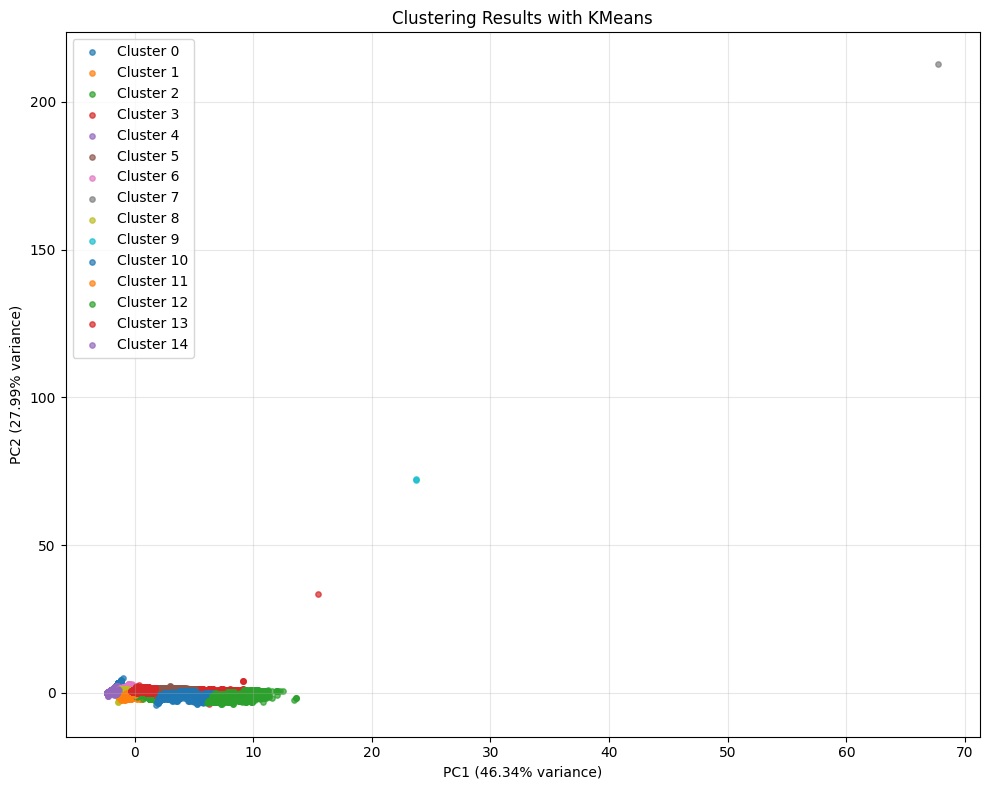

In [2]:
print("=== Power Quality Anomaly Analysis ===")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
overall_start = time.time()

# 1. Load data
step_start = time.time()
print("\n[Step 1/8] Loading anomalous data...")
df = load_anomalous_data()
print(f"Step 1 completed in {time.time() - step_start:.1f} seconds")

# 2. Preprocess data
step_start = time.time()
print("\n[Step 2/8] Preprocessing data...")
df = preprocess_data(df)
print(f"Step 2 completed in {time.time() - step_start:.1f} seconds")

# 3. Engineer features
step_start = time.time()
print("\n[Step 3/8] Engineering features...")
df = engineer_features(df)
print(f"Step 3 completed in {time.time() - step_start:.1f} seconds")

# 4. Reduce data while preserving patterns
step_start = time.time()
print("\n[Step 4/8] Reducing data...")
df_reduced = reduce_data(df, max_samples=100_000)  # Changed to 20,000 as per your suggestion
print(f"Step 4 completed in {time.time() - step_start:.1f} seconds")

# 5. Normalize data
step_start = time.time()
print("\n[Step 5/8] Normalizing data...")
scaled_df, feature_cols, scaler = normalize_data(df_reduced)
print(f"Step 5 completed in {time.time() - step_start:.1f} seconds")

# # 6. Visualize data
# step_start = time.time()
# print("\n[Step 6/8] Creating visualizations...")
# pca_result = visualize_data(df_reduced, scaled_df, feature_cols)
# print(f"Step 6 completed in {time.time() - step_start:.1f} seconds")

# 7. Perform clustering and evaluate
step_start = time.time()
print("\n[Step 7/8] Performing clustering analysis...")
results, metrics_df, best_model = perform_clustering(scaled_df, feature_cols)
print(f"Step 7 completed in {time.time() - step_start:.1f} seconds")

# 8. Analyze clusters
step_start = time.time()
print("\n[Step 8/8] Analyzing clusters...")
df_with_clusters, anomaly_mapping = analyze_clusters(df_reduced, scaled_df, results, best_model)
print(f"Step 8 completed in {time.time() - step_start:.1f} seconds")

overall_time = time.time() - overall_start
hours = int(overall_time // 3600)
minutes = int((overall_time % 3600) // 60)
seconds = int(overall_time % 60)

print("\n=== Analysis Complete ===")
print(f"Total execution time: {hours}h {minutes}m {seconds}s")
print(f"Results saved to 'clustered_anomalies.csv'")
print(f"Visualizations saved to 'plots/' directory")
print(f"Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

In [3]:
df_with_clusters.head()

timestamp  current  frequency  power  powerFactor  \
location                                                                       
Tugas    3709585 2025-04-21 19:56:49    0.202       60.0   32.4         0.78   
         3712003 2025-04-21 21:08:59    0.198       60.0   32.4         0.79   
         3306225 2025-04-16 21:15:06    0.199       60.0   32.8         0.81   
         3297359 2025-04-16 18:26:40    0.228       60.0   35.2         0.77   
         3445318 2025-04-18 14:11:01    0.000       60.0    0.0         0.00   

                  voltage  anomalous location  time_diff  latency  ...  \
location                                                           ...   
Tugas    3709585    204.4          1    Tugas        NaN      NaN  ...   
         3712003    206.6          1    Tugas        NaN      NaN  ...   
         3306225    204.6          1    Tugas        NaN      NaN  ...   
         3297359    199.3          1    Tugas        NaN      NaN  ...   
         3445318    205.0          1    Tugas        NaN      NaN  ...   

                  high_power very_high_power transient_flag surge_flag  \
location                                                                 
Tugas    3709585           0               0              1          0   
         3712003           0               0              1          0   
         3306225           0               0              1          0   
         3297359           0               0              1          0   
         3445318           0               0              1          0   

                 pf_issue_flag power_voltage_ratio  current_voltage_ratio  \
location                                                                    
Tugas    3709585             0            0.158435               0.000988   
         3712003             0            0.156749               0.000958   
         3306225             0            0.160234               0.000972   
         3297359             0            0.176530               0.001143   
         3445318             1            0.000000               0.000000   

                  voltage_bin  cluster                   anomaly_type  
location                                                               
Tugas    3709585          NaN       11  Light Load (Normal Operation)  
         3712003          NaN       11  Light Load (Normal Operation)  
         3306225          NaN       11  Light Load (Normal Operation)  
         3297359          NaN       11  Light Load (Normal Operation)  
         3445318          NaN       14       No Load (Idle Operation)  

[5 rows x 42 columns]

In [4]:
df_with_clusters.columns

Index(['timestamp', 'current', 'frequency', 'power', 'powerFactor', 'voltage',
       'anomalous', 'location', 'time_diff', 'latency', 'expected_power',
       'power_mismatch', 'powerFactor_efficiency', 'voltage_violation',
       'no_load', 'all_zero', 'voltage_deviation', 'frequency_deviation',
       'pf_deviation', 'severe_voltage_dip', 'moderate_voltage_dip',
       'mild_voltage_dip', 'mild_surge', 'moderate_surge', 'severe_surge',
       'severe_pf_issue', 'moderate_pf_issue', 'mild_pf_issue', 'freq_low',
       'freq_high', 'high_current', 'very_high_current', 'high_power',
       'very_high_power', 'transient_flag', 'surge_flag', 'pf_issue_flag',
       'power_voltage_ratio', 'current_voltage_ratio', 'voltage_bin',
       'cluster', 'anomaly_type'],
      dtype='object')

In [5]:
# Assuming your DataFrame is named df

df_with_clusters.loc[df_with_clusters['cluster'] == 3, ['timestamp', 'current', 'frequency', 'power', 'powerFactor', 'voltage', 'location']].head()

timestamp  current  frequency   power  \
location                                                              
SanFernando 2540733 2025-03-20 10:34:42   19.671       59.8  2191.0   
            2540715 2025-03-20 10:34:24   19.856       59.1  3770.4   
            2540701 2025-03-20 10:34:10   19.856       59.1  3770.4   
            2540716 2025-03-20 10:34:25   19.856       59.1  3770.4   
Lorega      1544976 2025-03-27 12:19:52   13.411       59.9  3260.5   

                     powerFactor  voltage     location  
location                                                
SanFernando 2540733         0.73    152.3  SanFernando  
            2540715         0.93    204.6  SanFernando  
            2540701         0.93    204.6  SanFernando  
            2540716         0.93    204.6  SanFernando  
Lorega      1544976         0.98    248.1       Lorega

In [6]:
# Assuming your DataFrame is named df

df_with_clusters.loc[df_with_clusters['cluster'] == 4, ['timestamp', 'current', 'frequency', 'power', 'powerFactor', 'voltage', 'location']].describe()

,timestamp,current,frequency,power,powerFactor,voltage
count,7914,7914.000000,7914.000000,7914.0,7914.0,7914.000000
mean,2025-03-25 00:34:29.114227968,0.000105,60.027015,0.0,0.0,238.636075
min,2025-02-28 17:16:15,0.000000,60.000000,0.0,0.0,225.200000
25%,2025-03-08 15:20:15.500000,0.000000,60.000000,0.0,0.0,237.100000
50%,2025-03-15 05:44:25,0.000000,60.000000,0.0,0.0,239.000000
75%,2025-04-17 03:50:11.750000128,0.000000,60.100000,0.0,0.0,241.000000
max,2025-04-21 18:10:14,0.052000,60.400000,0.0,0.0,247.100000
std,NaN,0.002325,0.045392,0.0,0.0,3.477441


In [8]:
def evaluate_clusters(df, scaled_df, feature_cols, n_clusters_list=[18, 20, 25], min_pct=0.01, random_state=42):
    """
    Evaluate clustering with specific numbers of clusters.
    
    Parameters:
    - df: Original dataframe with raw features
    - scaled_df: Scaled dataframe for clustering
    - feature_cols: Feature columns used for clustering
    - n_clusters_list: List of cluster counts to evaluate
    - min_pct: Minimum percentage of points a cluster should have
    - random_state: Random seed for reproducibility
    
    Returns:
    - Dictionary containing results for each n_clusters value
    """
    results = {}
    X = scaled_df[feature_cols].values
    metrics_df = pd.DataFrame(columns=['n_clusters', 'silhouette', 'davies_bouldin', 'calinski_harabasz'])
    
    print("Evaluating specific cluster counts...")
    
    for n_clusters in n_clusters_list:
        print(f"\nEvaluating n_clusters={n_clusters}...")
        
        # Create and fit KMeans model
        model = KMeans(n_clusters=n_clusters, random_state=random_state, verbose=0)
        start_time = time.time()
        labels = model.fit_predict(X)
        elapsed_time = time.time() - start_time
        
        # Calculate metrics
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        
        # Store metrics
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'n_clusters': [n_clusters],
            'silhouette': [silhouette],
            'davies_bouldin': [davies_bouldin],
            'calinski_harabasz': [calinski_harabasz]
        })], ignore_index=True)
        
        print(f"  Silhouette: {silhouette:.4f}")
        print(f"  Davies-Bouldin: {davies_bouldin:.4f}")
        print(f"  Calinski-Harabasz: {calinski_harabasz:.4f}")
        print(f"  Completed in {elapsed_time:.2f} seconds")
        
        # Add labels to dataframe for this n_clusters
        df_with_clusters = df.copy()
        df_with_clusters['cluster'] = labels
        
        # Analyze cluster sizes
        cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()
        small_clusters = cluster_counts[cluster_counts / len(df_with_clusters) < min_pct]
        
        print(f"  Cluster sizes range from {cluster_counts.min()} to {cluster_counts.max()} samples")
        if len(small_clusters) > 0:
            print(f"  Warning: {len(small_clusters)} clusters have less than {min_pct:.1%} of data:")
            for cluster, count in small_clusters.items():
                print(f"    - Cluster {cluster}: {count} samples ({count/len(df_with_clusters):.2%})")
        
        # Calculate cluster profiles for key metrics
        cluster_profiles = df_with_clusters.groupby('cluster')[
            ['voltage', 'current', 'frequency', 'power', 'powerFactor', 
             'severe_voltage_dip', 'moderate_voltage_dip', 'severe_surge',
             'severe_pf_issue', 'moderate_pf_issue', 'pf_deviation']
        ].mean()
        
        print("\nCluster centroids (key metrics):")
        print(cluster_profiles[['voltage', 'current', 'power', 'powerFactor']].round(2))
        
        # Store results for this n_clusters
        results[n_clusters] = {
            'labels': labels,
            'metrics': {
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski_harabasz': calinski_harabasz
            },
            'cluster_counts': cluster_counts,
            'small_clusters': small_clusters,
            'cluster_profiles': cluster_profiles,
            'model': model
        }
        
        # Plot cluster sizes
        plt.figure(figsize=(12, 6))
        ax = cluster_counts.plot(kind='bar')
        plt.axhline(y=min_pct * len(df_with_clusters), color='r', linestyle='--', 
                   label=f'Minimum size ({min_pct:.1%} of data)')
        plt.title(f'Cluster Sizes (n_clusters={n_clusters})')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Samples')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.savefig(f'plots/cluster_sizes_{n_clusters}.png')
        
        # Visualize clusters with PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        plt.figure(figsize=(10, 8))
        for cluster in range(n_clusters):
            plt.scatter(
                X_pca[labels == cluster, 0],
                X_pca[labels == cluster, 1],
                alpha=0.7, s=15
            )
        
        plt.title(f'PCA Visualization of {n_clusters} Clusters')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.grid(alpha=0.3)
        plt.savefig(f'plots/pca_clusters_{n_clusters}.png')
    
    # Compare metrics across different n_clusters
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(metrics_df['n_clusters'], metrics_df['silhouette'], 'o-')
    plt.title('Silhouette Score (higher is better)')
    plt.grid(alpha=0.3)
    
    plt.subplot(3, 1, 2)
    plt.plot(metrics_df['n_clusters'], metrics_df['davies_bouldin'], 'o-')
    plt.title('Davies-Bouldin Index (lower is better)')
    plt.grid(alpha=0.3)
    
    plt.subplot(3, 1, 3)
    plt.plot(metrics_df['n_clusters'], metrics_df['calinski_harabasz'], 'o-')
    plt.title('Calinski-Harabasz Index (higher is better)')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/clustering_metrics_comparison.png')
    
    # Print summary table
    print("\nMetrics summary:")
    print(metrics_df.set_index('n_clusters'))
    
    # Determine best n_clusters based on metrics
    best_silhouette = metrics_df.loc[metrics_df['silhouette'].idxmax()]['n_clusters']
    best_davies = metrics_df.loc[metrics_df['davies_bouldin'].idxmin()]['n_clusters']
    best_ch = metrics_df.loc[metrics_df['calinski_harabasz'].idxmax()]['n_clusters']
    
    print(f"\nOptimal n_clusters:")
    print(f"  Based on Silhouette Score: {int(best_silhouette)}")
    print(f"  Based on Davies-Bouldin Index: {int(best_davies)}")
    print(f"  Based on Calinski-Harabasz Index: {int(best_ch)}")
    
    return results, metrics_df

Evaluating specific cluster counts...

Evaluating n_clusters=18...


C:\Users\Alvin\AppData\Local\Temp\ipykernel_4568\1590794893.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


  Silhouette: 0.5463
  Davies-Bouldin: 0.6753
  Calinski-Harabasz: 86913.8779
  Completed in 0.25 seconds
  Cluster sizes range from 1 to 26347 samples
    - Cluster 3: 856 samples (0.86%)
    - Cluster 7: 1 samples (0.00%)
    - Cluster 9: 2 samples (0.00%)

Cluster centroids (key metrics):
         voltage  current    power  powerFactor
cluster                                        
0         239.76     0.00     0.00         0.00
1         222.18     0.38    63.14         0.76
2         240.13     0.86   177.69         0.87
3         237.09    19.51  4467.59         0.97
4         238.36     0.00     0.00         0.00
5         240.90     5.89  1309.95         0.92
6         235.95     0.39    46.88         0.50
7        2669.05    19.69  4248.80         0.93
8         233.44     0.29    33.97         0.43
9         219.98    19.69  4248.80         0.93
10        238.95     6.89  1459.81         0.89
11        206.20     0.45    70.26         0.77
12        241.52    21.96  5171.37 

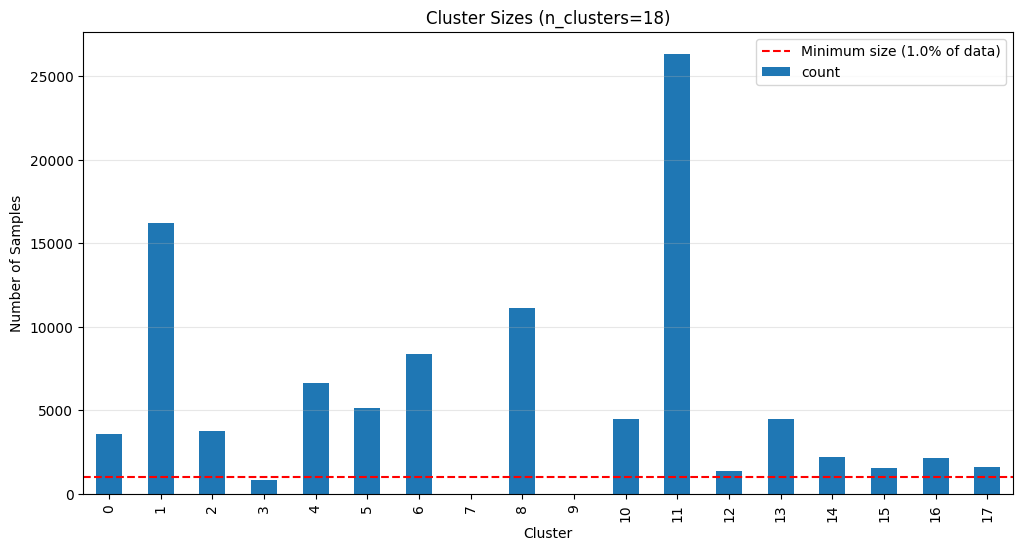

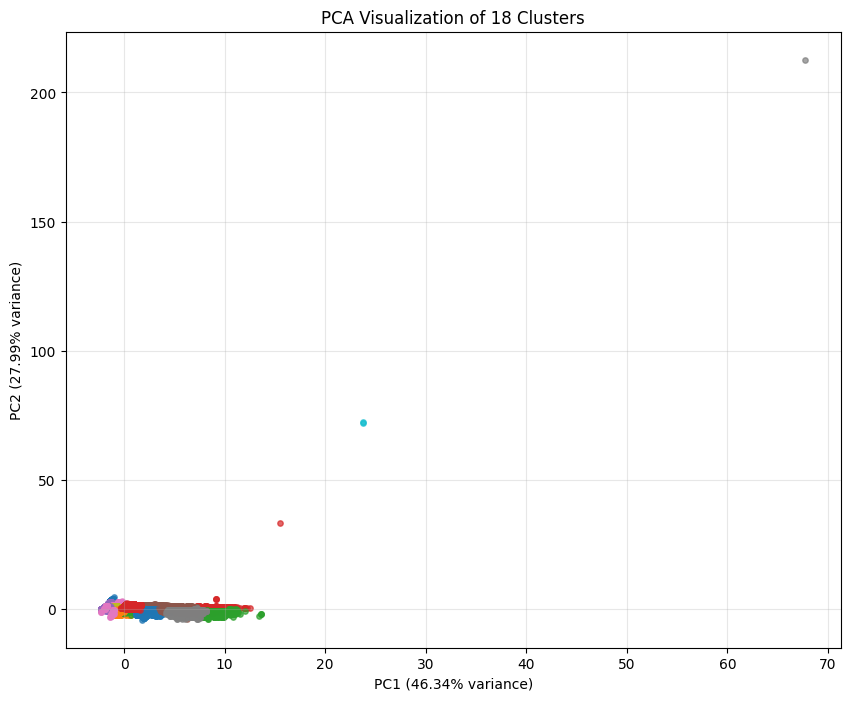

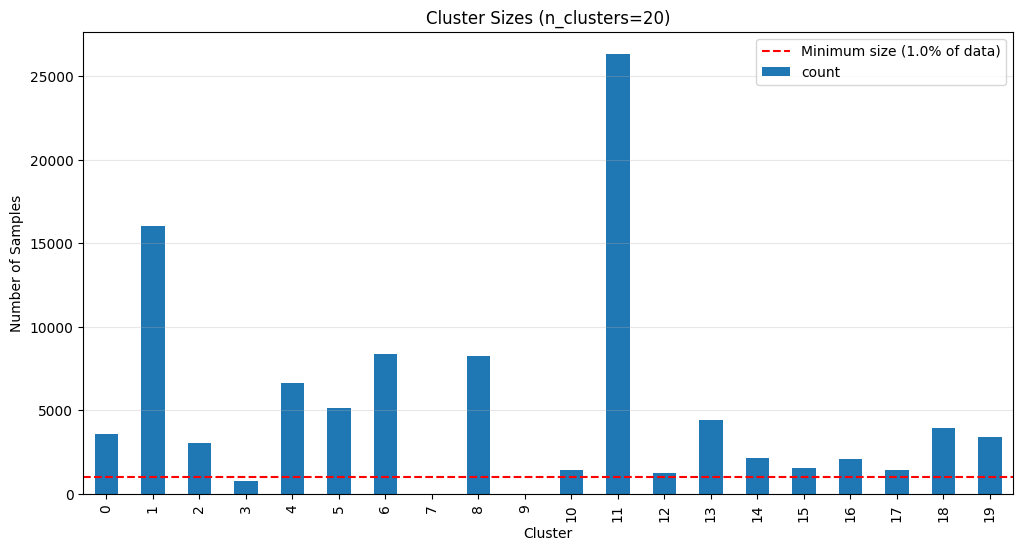

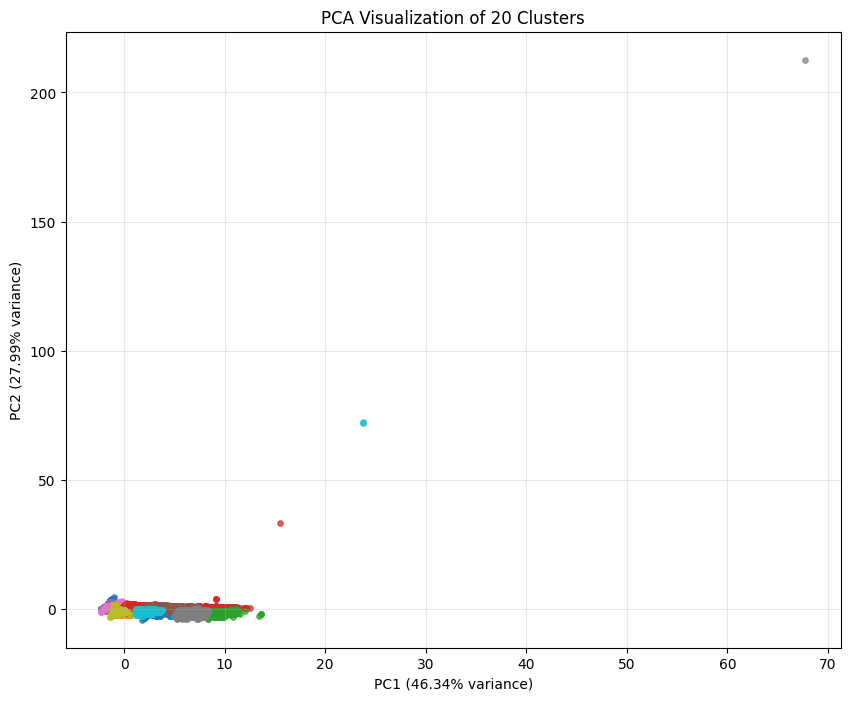

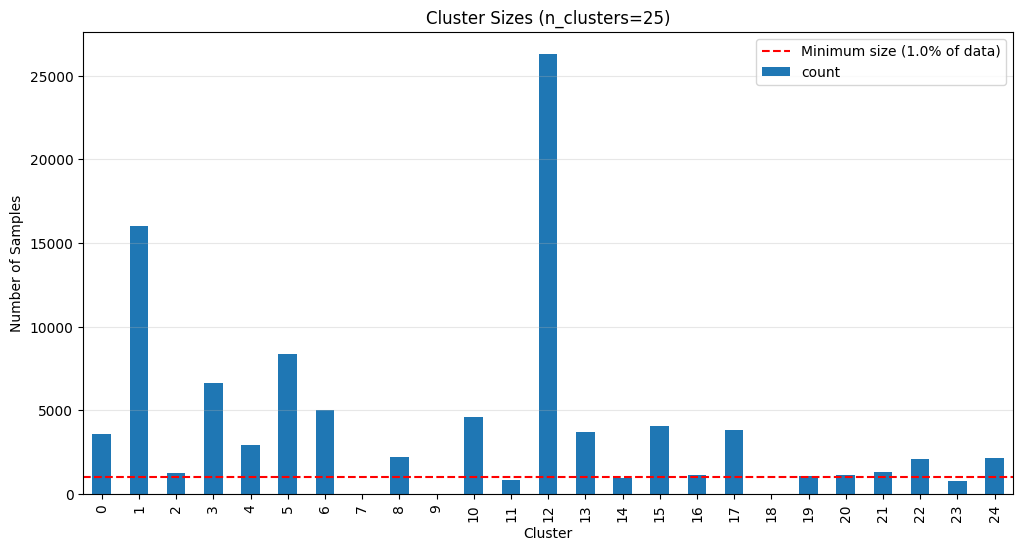

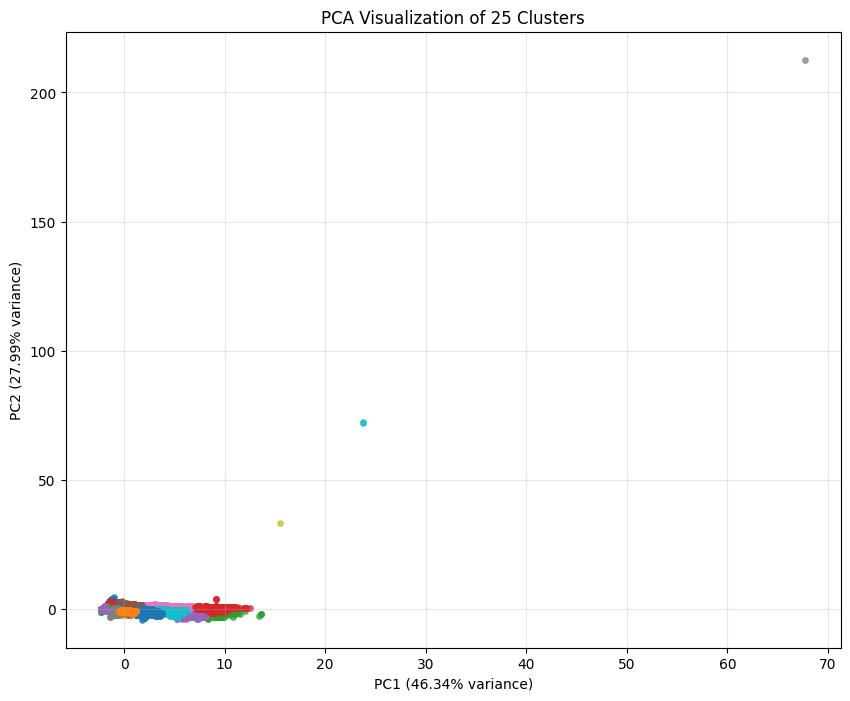

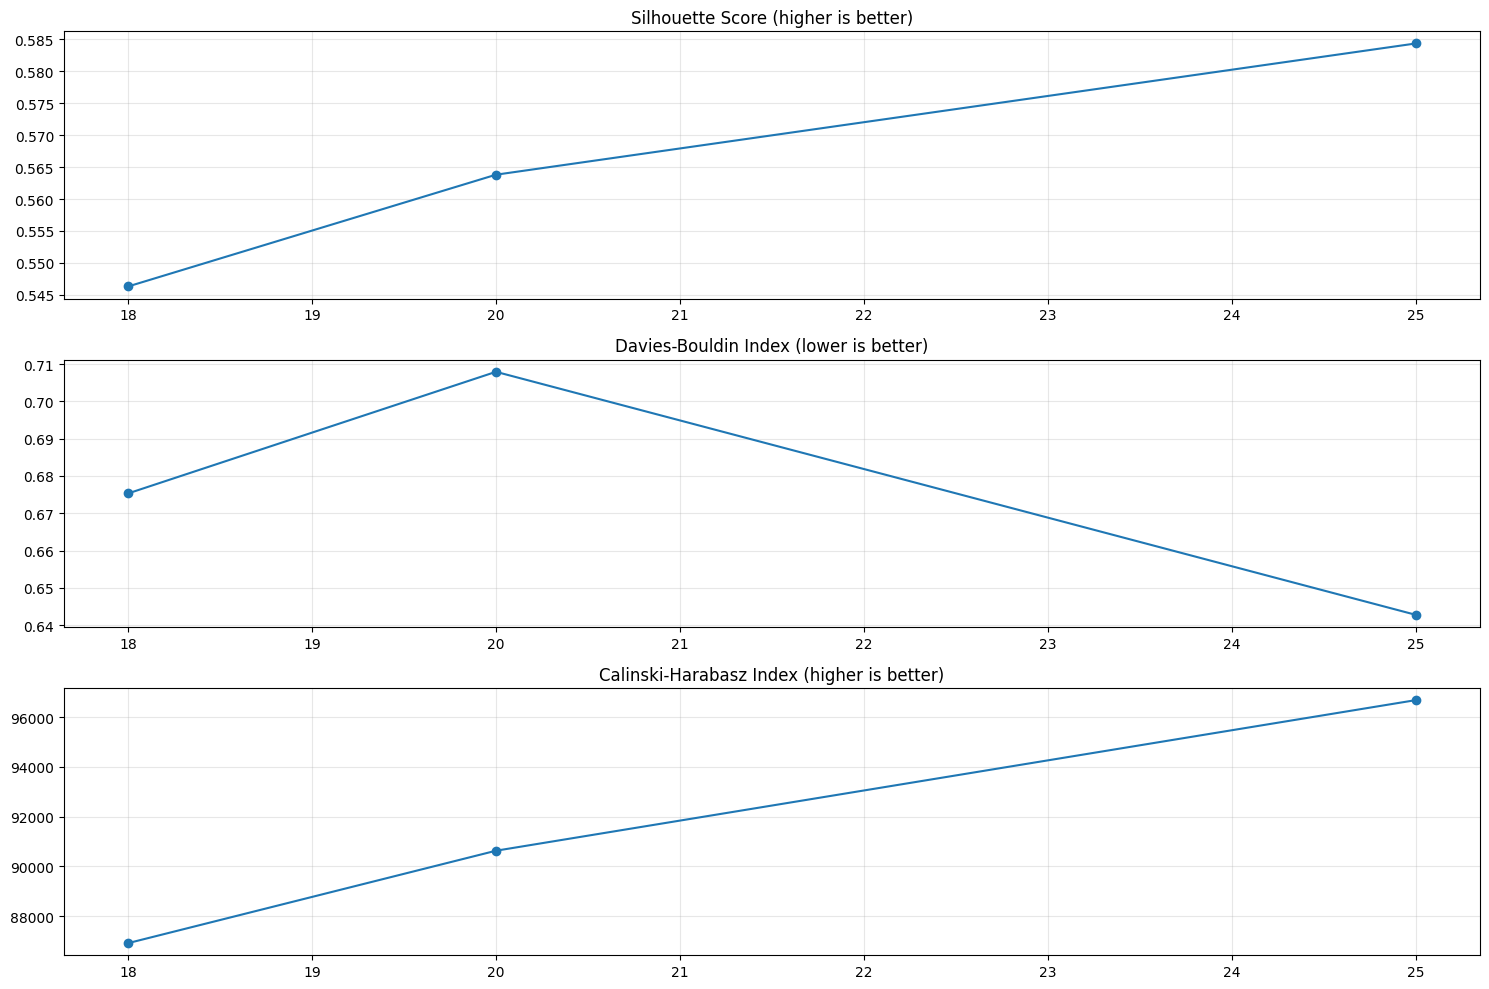

In [10]:
# After your preprocessing, feature engineering, and normalizing steps
# Run the evaluation on specific cluster counts
cluster_results, metrics_summary = evaluate_clusters(
    df_reduced, 
    scaled_df, 
    feature_cols,
    n_clusters_list=[18, 20, 25]
)

# To select the best model from results
best_n = int(metrics_summary.loc[metrics_summary['silhouette'].idxmax()]['n_clusters'])
print(f"Best number of clusters based on silhouette: {best_n}")

# Use the best model
best_model = cluster_results[best_n]['model']
df_with_clusters = df_reduced.copy()
df_with_clusters['cluster'] = cluster_results[best_n]['labels']

# Continue with your anomaly mapping
# df_with_clusters['anomaly_type'] = ...

In [17]:
# Assuming your DataFrame is named df

df_with_clusters.loc[df_with_clusters['cluster'] == 12, ['timestamp', 'current', 'frequency', 'power', 'powerFactor', 'voltage', 'location']].head()

timestamp  current  frequency  power  powerFactor  \
location                                                                       
Tugas    3709585 2025-04-21 19:56:49    0.202       60.0   32.4         0.78   
         3712003 2025-04-21 21:08:59    0.198       60.0   32.4         0.79   
         3306225 2025-04-16 21:15:06    0.199       60.0   32.8         0.81   
         3297359 2025-04-16 18:26:40    0.228       60.0   35.2         0.77   
         3388690 2025-04-17 21:44:24    0.198       60.0   32.7         0.81   

                  voltage location  
location                            
Tugas    3709585    204.4    Tugas  
         3712003    206.6    Tugas  
         3306225    204.6    Tugas  
         3297359    199.3    Tugas  
         3388690    204.9    Tugas

    - Cluster 7: 1 samples (0.00%)
    - Cluster 9: 2 samples (0.00%)
    - Cluster 11: 825 samples (0.83%)
    - Cluster 14: 981 samples (0.98%)
    - Cluster 18: 1 samples (0.00%)
    - Cluster 23: 762 samples (0.76%)


In [16]:
# Create anomaly mapping based on cluster profiles
anomaly_mapping = {}
cluster_profiles = df_with_clusters.groupby('cluster')[
    ['voltage', 'current', 'frequency', 'power', 'powerFactor', 
    'transient_flag', 'surge_flag', 'pf_issue_flag',
    'severe_voltage_dip', 'moderate_voltage_dip', 'mild_voltage_dip',
    'mild_surge', 'moderate_surge', 'severe_surge', 
    'severe_pf_issue', 'moderate_pf_issue', 'mild_pf_issue',
    'freq_low', 'freq_high',
    'high_current', 'very_high_current', 'high_power', 'very_high_power',
    'voltage_deviation', 'frequency_deviation', 'pf_deviation',
    'power_voltage_ratio', 'current_voltage_ratio'
    ]
].mean()

# Map clusters to anomaly types using the same rules from analyze_clusters
for cluster in cluster_profiles.index:
    profile = cluster_profiles.loc[cluster]
    
    # Apply the same anomaly classification logic as in your analyze_clusters function
    if profile['current'] < 0.01 and profile['power'] < 1.0:
        anomaly_type = "No Load (Idle Operation)"
    elif profile['current'] < 2.0 and profile['power'] < 400.0 and profile['powerFactor'] >= 0.75:
        anomaly_type = "Light Load (Normal Operation)"
    elif profile['severe_voltage_dip'] > 0.3:
        anomaly_type = "Severe Voltage Dip"
    elif profile['severe_surge'] > 0.3:
        anomaly_type = "Severe Voltage Surge"
    elif profile['very_high_power'] > 0.5 and profile['powerFactor'] > 0.9:
        anomaly_type = "Very High Load (Good PF)"
    elif profile['very_high_power'] > 0.5 and profile['powerFactor'] < 0.75:
        anomaly_type = "Very High Load with PF Issues"
    elif profile['high_current'] > 0.5 and profile['moderate_pf_issue'] > 0.5:
        anomaly_type = "High Current with PF Issues"
    elif profile['moderate_voltage_dip'] > 0.3:
        anomaly_type = "Moderate Voltage Dip"
    elif profile['moderate_surge'] > 0.3:
        anomaly_type = "Moderate Voltage Surge"
    elif profile['severe_pf_issue'] > 0.3:
        anomaly_type = "Severe Power Factor Issue"
    elif profile['moderate_pf_issue'] > 0.5:
        anomaly_type = "Moderate Power Factor Issue"
    elif profile['mild_pf_issue'] > 0.5:
        anomaly_type = "Mild Power Factor Issue"
    elif profile['freq_low'] > 0.3:
        anomaly_type = "Low Frequency"
    elif profile['freq_high'] > 0.3:
        anomaly_type = "High Frequency"
    elif (profile['power'] > 1000 and profile['current'] > 5):
        anomaly_type = "High Load Operation"
    elif profile['pf_deviation'] > 0.1:
        anomaly_type = "Minor Power Factor Deviation"
    else:
        anomaly_type = "Normal Operation"
    
    anomaly_mapping[cluster] = anomaly_type

# Add anomaly types to the DataFrame
df_with_clusters['anomaly_type'] = df_with_clusters['cluster'].map(anomaly_mapping)

# Print cluster to anomaly type mapping
print("\nCluster to anomaly type mapping:")
for cluster, anomaly_type in sorted(anomaly_mapping.items()):
    print(f"  Cluster {cluster} → {anomaly_type}")

# Save to CSV
output_filename = f'clustered_anomalies_{best_n}_clusters.csv'
df_with_clusters.to_csv(output_filename, index=False)
print(f"\nResults saved to '{output_filename}'")


Cluster to anomaly type mapping:
  Cluster 0 → No Load (Idle Operation)
  Cluster 1 → Light Load (Normal Operation)
  Cluster 2 → Very High Load (Good PF)
  Cluster 3 → No Load (Idle Operation)
  Cluster 4 → High Load Operation
  Cluster 5 → Moderate Power Factor Issue
  Cluster 6 → High Load Operation
  Cluster 7 → Severe Voltage Surge
  Cluster 8 → Light Load (Normal Operation)
  Cluster 9 → Very High Load (Good PF)
  Cluster 10 → Moderate Power Factor Issue
  Cluster 11 → Very High Load (Good PF)
  Cluster 12 → Light Load (Normal Operation)
  Cluster 13 → Severe Power Factor Issue
  Cluster 14 → Very High Load (Good PF)
  Cluster 15 → Light Load (Normal Operation)
  Cluster 16 → Mild Power Factor Issue
  Cluster 17 → Moderate Power Factor Issue
  Cluster 18 → Very High Load (Good PF)
  Cluster 19 → Mild Power Factor Issue
  Cluster 20 → Mild Power Factor Issue
  Cluster 21 → Light Load (Normal Operation)
  Cluster 22 → No Load (Idle Operation)
  Cluster 23 → Very High Load (Good PF

Collecting workspace information# Chapter 4: Results and Discussion for Your Thesis

Based on your workspace and thesis document, Chapter 4 should focus on presenting the results of your clustering-based anomaly detection system and its integration with XAI. Here's how you should structure this chapter:

## 4.1 Anomaly Detection Results

### 4.1.1 Clustering Performance Evaluation
- Present the comparison of clustering algorithms (KMeans, SpectralClustering, AgglomerativeClustering, etc.)
- Include tables showing silhouette scores, Davies-Bouldin and Calinski-Harabasz indices
- Include visualizations from the plots directory, especially the PCA projections
- Discuss why the best model was selected based on these metrics



In [ ]:
# Sample table content for your clustering evaluation
results_table = pd.DataFrame({
    'Algorithm': ['KMeans', 'SpectralClustering', 'AgglomerativeClustering', 'GaussianMixture'],
    'Silhouette Score': [0.xyz, 0.xyz, 0.xyz, 0.xyz],
    'Davies-Bouldin Index': [0.xyz, 0.xyz, 0.xyz, 0.xyz],
    'Calinski-Harabasz Index': [0.xyz, 0.xyz, 0.xyz, 0.xyz]
})



### 4.1.2 Anomaly Classification Results
- Present the anomaly mapping results from `anomaly_mapping` in your code
- Include tables showing anomaly distribution across different locations
- Show representative examples of each anomaly type
- Discuss patterns observed in different areas of Cebu

## 4.2 XAI Integration (SHAP Analysis)

> **Note:** This section requires implementing SHAP analysis, which is currently missing from your code

### 4.2.1 Global Feature Importance
- Implement and present SHAP analysis of the clustered data
- Show which features (voltage, current, etc.) are most important for anomaly detection
- Include visualizations like SHAP summary plots



In [ ]:
# Example code to add to your implementation
import shap

# Create explainer for your model
explainer = shap.KernelExplainer(model.predict, X_background)
shap_values = explainer.shap_values(X_test)

# Create global feature importance visualization
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)



### 4.2.2 Local Explanations for Anomalies
- Show SHAP analysis for specific anomaly instances
- Include visualizations of local explanations
- Use real examples from different locations in Cebu

### 4.2.3 Evaluation of XAI Metrics
Based on your thesis section 3.17:

1. **Consistency Metric**
   - Implement and evaluate whether different XAI methods provide consistent explanations
   - Compare results from different approaches (SHAP vs LIME)

2. **Stability Metric**
   - Test how robust the explanations are when input data has minor variations
   - Present stability scores using the Shapash library

3. **Compacity Metric**
   - Analyze whether a small subset of features adequately explains predictions
   - Present compacity plots showing explanation quality vs. number of features

## 4.3 Case Studies from Cebu Power Grid

### 4.3.1 Voltage Anomaly Analysis
- Present specific cases of voltage anomalies detected at different locations
- Include SHAP explanations for each case
- Discuss potential causes and implications

### 4.3.2 Power Factor Issues
- Present specific cases of power factor anomalies
- Include SHAP explanations showing why these were flagged
- Discuss implications for grid efficiency

### 4.3.3 Cross-Location Comparison
- Compare anomaly patterns across different utility providers in Cebu
- Use SHAP to explain differences between locations
- Connect findings to specific grid characteristics

## 4.4 Practical Applications and Recommendations

- Discuss how utility providers can use these explanations
- Provide actionable insights based on the detected anomalies
- Suggest preventive measures for common anomalies

---

To complete this chapter, you need to:

1. **Add SHAP implementation** to your existing code in process.ipynb:
   ```python
   # After clustering and anomaly mapping
   import shap
   
   # Create a function to analyze clusters with SHAP
   def explain_clusters_with_shap(df, scaled_df, feature_cols, best_model, cluster_labels):
       # Implementation details here
   ```

2. **Implement the evaluation metrics** mentioned in your thesis:
   ```python
   # Add consistency, stability, and compacity evaluation
   def evaluate_xai_metrics(df, shap_values, feature_cols):
       # Implementation details here
   ```

3. **Extract specific case studies** from your dataset for detailed analysis.

Remember to connect your findings back to the objectives stated in your thesis, particularly "Identify the critical electrical parameters that caused the anomaly through XAI, specifically using Shapley values."